# Training Models in PyTorch

This notebook is a tutorial accompying the manuscript "Perspectives: Comparison of Deep Learning Based Segmentation Models on Typical Biophysics and Biomedical Data" by JS Bryan IV, M Tavakoli, and S Presse. In this tutorial, we will learn the basics of training models in PyTorch.

**Before reading this tutorial, make sure you have properly installed PyTorch and downloaded the data as explained in this repository's README.**

## Introduction

In this tutorial, we will train a simple convolutional neural network (CNN) to train models in PyTorch. We will specifically train a simple model to segment the Chinese characters from the images in the dataset. The specific aim of this tutorial is the explain the training function defined in the `training.py` of this repository.

### Importing libraries

<!-- # Import libraries
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader -->

Before we start, let's import the necessary libraries. To get started here are the libraries we will use:

* os: To handle file paths.
* torch: To access PyTorch functionalities.
* torch.nn: To access PyTorch's neural network functionalities.
* torch.nn.functional: To access PyTorch's functional neural network functionalities.
* matplotlib.pyplot: To plot images and graphs.
* torch.utils.data.DataLoader: To load data in batches.

In [1]:
# Import libraries
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


### Defining the model

We will define a simple CNN model with two convolutional layers and two fully connected layers. The model will be defined as a class `SimpleCNN` that inherits from `nn.Module`. For more information on defining models in PyTorch, please check out our tutorial on models in PyTorch.

## The parts of training a model

When we creat a model in PyTorch, the weights are initialized to random values. The goal of training is to adjust these weights so that the model can make accurate predictions. In order to train the model we need to define the following components:

1) **Dataset**: The dataset that we will use to train the model. We will use the `ChineseCharacters` dataset in this tutorial.
2) **Model**: The neural network model that we want to train.
3) **Loss Function**: The loss function that we will use to calculate the error between the predicted and actual values.
4) **Optimizer**: The optimizer that we will use to adjust the weights of the model.

Let us go through each of these components in detail.

### Dataset

We will use the `ChineseCharacters` dataset to train the model. The dataset contains images of Chinese characters along with their segmentation masks. We will import the dataset from our `data/` directory, instantiate the dataset, and then split it into training, validation, and testing sets. The training set will be used to train the model, the validation set will be used to stop training when the model starts overfitting, and the testing set will be used to evaluate the model's performance. We will also create a `DataLoader` for each set to load the data in batches.

In [2]:
# Import custom Chinese Characters dataset
basedir = os.path.dirname(os.getcwd())
datadir = os.path.join(basedir, 'data')
sys.path.append(datadir)
from letters import ChineseCharacters

# Load the dataset
dataset = ChineseCharacters()

# Split the dataset
n_train = int(0.6 * len(dataset))
n_val = int(0.2 * len(dataset))
n_test = len(dataset) - n_train - n_val
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# Set up data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/Users/jbryaniv/Desktop/Projects/BioModelComparison/.env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To visualize what the data looks like, we will plot a few images and their corresponding masks.

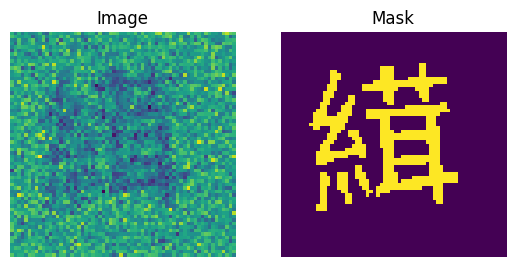

In [3]:
# Get the first image and mask of the next batch
img, mask = next(iter(train_loader))
img = img[0]
mask = mask[0]

# Visualize the first image and mask
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img.numpy().transpose(1, 2, 0))  # Transpose the image tensor to (H, W, C)
ax[0].set_title('Image')
ax[0].axis('off')
ax[1].imshow(mask.numpy())  # The mask is a single channel tensor
ax[1].set_title('Mask')
ax[1].axis('off')
plt.show()

### Model

We will define a simple CNN model with two convolutional layers and two fully connected layers. The model will be defined as a class `SimpleCNN` that inherits from `nn.Module`. For more information on defining models in PyTorch, please check out our tutorial on models in PyTorch.

We will define the model and then instantiate it. Notice that we have 1 input channel (since the images are grayscale) and 2 output channels (one representing the background and the other representing the Chinese characters).


In [4]:
# Define the ConvolutionalNet class
class ConvolutionalNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_features=8, n_layers=2):
        super(ConvolutionalNet, self).__init__()

        # Set up attributes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_features = n_features
        self.n_layers = n_layers

        # Set up input block
        self.input_block = nn.Sequential(
            nn.GroupNorm(1, in_channels, affine=False),  # Normalize input
            nn.Conv2d(in_channels, n_features, kernel_size=3, padding=1),
        )

        # Set up layers
        self.conv_block = nn.ModuleList()
        for _ in range(self.n_layers):
            self.conv_block.append(nn.Sequential(
                nn.Conv2d(n_features, n_features, kernel_size=3, padding=1),
                nn.InstanceNorm2d(n_features),
                nn.ReLU(),
            ))

        # Set up output block
        self.output_block = nn.Sequential(
            nn.Conv2d(self.n_features, out_channels, kernel_size=1),
        )

    def forward(self, x):
        """Forward pass."""

        # Input block
        x = self.input_block(x)

        # Convolutional block
        for layer in self.conv_block:
            x = layer(x)

        # Output block
        x = self.output_block(x)

        # Return
        return x
    
# Instantiate the model
model = ConvolutionalNet(1, 2, n_features=8, n_layers=2)

This model is instantiated, but not yet trained. Let us look at the output of the model before training so we can compare it to the output after training.

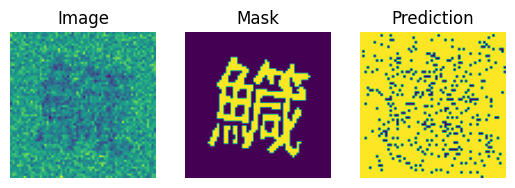

In [5]:
# Get next batch
img, mask = next(iter(train_loader))

# Forward pass
output = model(img)
prediction = output.argmax(dim=1).squeeze()

# Visualize the first image and mask
fig, ax = plt.subplots(1, 3)
ax[0].set_title('Image')
ax[0].axis('off')
ax[0].imshow(img[0].numpy().transpose(1, 2, 0))  # Transpose the image tensor to (H, W, C)
ax[1].set_title('Mask')
ax[1].axis('off')
ax[1].imshow(mask[0].numpy())  # The mask is a single channel tensor
ax[2].set_title('Prediction')
ax[2].axis('off')
ax[2].imshow(prediction[0].detach().numpy())  # The output is a two-channel tensor
plt.show()

At this stage, the ouput prediction will be random since the model has not been trained yet. Notice that if you rerun the cell after training the model, the output will be different. Try not to rerun the cell after training the model in order to preserve the random output.

### Loss Function

The loss function is used to calculate the error between the predicted and actual values. Our model takes in a noisy image of a Chinese Character then output the logits of two classes, one for the background and one for the character. We will use the `CrossEntropyLoss` function to calculate the loss. For more information on loss functions in PyTorch, please check out our tutorial on loss functions in PyTorch.

We will also add a regularization term to the loss to prevent overfitting. The regularization term is the sum of the squares of the weights of the model divided by the number of weights.

In [6]:
# Set up loss
criterion = nn.CrossEntropyLoss()

# Set up regularization
def regularization(model):
    return (
        sum(p.pow(2.0).sum() for p in model.parameters()) 
        / sum(p.numel() for p in model.parameters())
    )

### Optimizer

The optimizer is used to adjust the weights of the model based on the loss calculated by the loss function at each iteration of the training process. We will use the `Adam` optimizer with a learning rate of 0.001.

In [7]:
# Set up optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Training loop

Now that we have set up the model, the dataset, the loss function, and the optimizer, we can define the training loop. The training loop consists of the following steps, which are run every iteration of the training process:

1) **Get the data**: Get a batch of data from the training set. This is done by iterating over the `DataLoader`.
2) **Zero the gradients**: Zero the gradients of the model so that they do not accumulate. This is done by calling `optimizer.zero_grad()`.
3) **Forward pass**: Pass the data through the model to get the predicted values. This is done by calling the model with the data as input, `model(data)`.
4) **Calculate the loss**: Calculate the loss using the predicted values and the actual values. This is done by calling the loss function with the predicted values and the actual values, `loss(pred, target)`.
5) **Backward pass**: Backpropagate the loss to adjust the weights of the model. This is done by calculating the gradients of the loss with respect to the weights of the model with `loss.backward()`.
6) **Update the weights**: Update the weights of the model using the optimizer. This is done by calling `optimizer.step()`.

Additionally, at the end of each epoch we will test the model on the validation set, save the model if it performs better than the previous best model, and print the loss and accuracy of the model on the training and validation sets.

We package the training loop into a function called `train_model` that takes in the model, the training and validation datasets, the loss function, the optimizer, and the number of epochs to train for. The function will train the model for the specified number of epochs and return the trained model.

Not that for tutorial purposes, we will only train for 3 epochs so that the training process is faster. In practice, you would train for many more epochs to get a well-trained model.

In [8]:
# Define training function
def train_model(model, train_loader, val_loader, n_epochs=100):
    print('Training model...')

    # Best loss
    best_loss = float('inf')
    best_loss_path = 'best_model.pth'

    # Loop over epochs
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')

        # Set model to training mode
        model.train()

        # Loop over training data
        for img, mask in train_loader:  # Step 1) Get data

            # Step 2) Zero gradients
            optimizer.zero_grad()

            # Step 3) Forward pass
            output = model(img)

            # Step 4) Compute loss
            loss = (
                criterion(output, mask)
                + regularization(model)
            )

            # Step 5) Backward pass
            loss.backward()

            # Step 6) Update model
            optimizer.step()
        
        # Evaluate model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for img, mask in val_loader:
                output = model(img)
                val_loss += criterion(output, mask).item()
        val_loss /= len(val_loader)
        print(f'Validation loss: {val_loss}')

        # Save best model
        if val_loss <= best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_loss_path)

    # Load best model
    model.load_state_dict(torch.load(best_loss_path))
    os.remove(best_loss_path)

    # Return best model
    return model

# Train the model
model = train_model(model, train_loader, val_loader, n_epochs=3)  # Only train for 3 epochs for demonstration purposes

Training model...
Epoch 1/3
Validation loss: 0.19943938596230565
Epoch 2/3
Validation loss: 0.14716044982725923
Epoch 3/3
Validation loss: 0.1338233184069395


Now that we have trained our model, let us visualize the output of the model on a sample to see how well it performs.

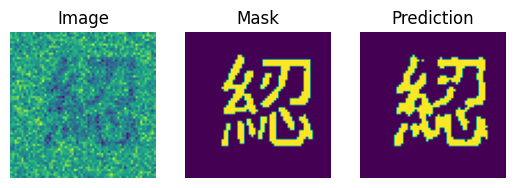

In [9]:
# Get next batch
img, mask = next(iter(train_loader))

# Forward pass
output = model(img)
prediction = output.argmax(dim=1).squeeze()

# Visualize the first image and mask
fig, ax = plt.subplots(1, 3)
ax[0].set_title('Image')
ax[0].axis('off')
ax[0].imshow(img[0].numpy().transpose(1, 2, 0))  # Transpose the image tensor to (H, W, C)
ax[1].set_title('Mask')
ax[1].axis('off')
ax[1].imshow(mask[0].numpy())  # The mask is a single channel tensor
ax[2].set_title('Prediction')
ax[2].axis('off')
ax[2].imshow(prediction[0].detach().numpy())  # The output is a two-channel tensor
plt.show()

The output after training should more closely match the target masks than the output before training. Keep in mind that the output may not be perfect, since we are using a rather simple model with few parameters.

## Conclusion

In this tutorial we learned how to train a simple CNN model in PyTorch. We defined the dataset, model, loss function, and optimizer, and then trained the model using a training loop. We also visualized the output of the model before and after training to see how well it performs.